In [35]:
import datetime
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader as DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
from matplotlib import pyplot as plt
from melSpecDataset import MelSpecDataset
import basic_model as net0
import MusicRecNet as net1

In [36]:
#set run choices
loss_plot = True
verbose = True
epoch_save = False

# set variables
train_dir = './images/training'
#test_dir = './images/testing/'
gamma = 0.1
num_epochs = 10
batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-3
rho = 0.9
eps = 1e-06

In [37]:
device = torch.device("cpu")

#need to change based on model name
#this calls the constructor of model class setting the choosen model for the run
################################################################################
#model = net0.GenreClassificationANN()
model = net1.MusicClassNet()

################################################################################
#dataloader
resize_size = (128, 128)
transform = Compose([
    Resize(resize_size),
    ToTensor()
])

train_dataset = MelSpecDataset(train_dir, transform)
data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#model optimizer
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=rho, eps=eps, weight_decay=weight_decay )

#model scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

# loss function
loss_function = nn.CrossEntropyLoss()

In [38]:
def train():
    model.train()
    model.to(device)

    epoch_losses = []
    n_images = 800
    n_batches = int(n_images/batch_size)

    for epoch in range(1, num_epochs+1):
        batch_loss = 0
        print(f'Epoch #{epoch}, Start Time: {datetime.datetime.now()}')

        for melspecs, labels in data_loader:
            #print(melspecs.shape)
            #print(labels)
            audios = melspecs.to(device)
            labels = labels.to(device)
        
            # calculate losses and call call model
            output = model(audios)
            

            # batch loss
            loss = loss_function(output, labels)
            batch_loss += loss.item()

            # backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # save epoch loss
        epoch_losses += [batch_loss/n_batches]
        scheduler.step(epoch_losses[-1])

        if verbose:
            print(f'Epoch: #{epoch}, Loss: {epoch_losses[epoch-1]}')

        if epoch_save:
            model_folder_dir = './temp_models'
            if not os.path.isdir(model_folder_dir):
                os.mkdir(model_folder_dir)

             # save temp model
            try:
                temp_model_path = model_folder_dir + '/' + str(datetime.datetime.now()) + '_epoch' + str(epoch) + '.pth'
                torch.save(model.state_dict(), temp_model_path)
                if verbose:
                    print(f'Saved model for epoch {epoch} @{temp_model_path}')
            except:
                print('Epoch model save failed')

    #save final model parameters   
    torch.save(model.state_dict(), f'model.pth')

    # save final loss plot
    if not os.path.exists("./plots"):
        os.makedirs("./plots")
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    generate_loss_plot(epoch_losses, f'./plots/loss_plot_{timestamp}.png', show_plot=loss_plot)

def generate_loss_plot(loss, file_loc, show_plot=False):
    epochs = list(range(1, len(loss)+1))
    plt.plot(epochs, loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.savefig(file_loc)
    if show_plot:
        plt.show()
    plt.close()

Epoch #1, Start Time: 2023-12-02 21:36:08.584987
Epoch: #1, Loss: 2.514169534047445
Epoch #2, Start Time: 2023-12-02 21:36:18.918709
Epoch: #2, Loss: 2.5002389947573342
Epoch #3, Start Time: 2023-12-02 21:36:29.228664
Epoch: #3, Loss: 2.5058266719182334
Epoch #4, Start Time: 2023-12-02 21:36:39.698215
Epoch: #4, Loss: 2.50524894396464
Epoch #5, Start Time: 2023-12-02 21:36:50.223603
Epoch: #5, Loss: 2.5040311217308044
Epoch #6, Start Time: 2023-12-02 21:37:00.762538
Epoch: #6, Loss: 2.497516453266144
Epoch #7, Start Time: 2023-12-02 21:37:11.416503
Epoch: #7, Loss: 2.496869921684265
Epoch #8, Start Time: 2023-12-02 21:37:22.003870
Epoch: #8, Loss: 2.4949652751286826
Epoch #9, Start Time: 2023-12-02 21:37:32.739588
Epoch: #9, Loss: 2.5028820236523948
Epoch #10, Start Time: 2023-12-02 21:37:43.521002
Epoch: #10, Loss: 2.4897567431131997


OSError: [Errno 22] Invalid argument: './plots/loss_plot_2023-12-02 21:37:54.333744.png'

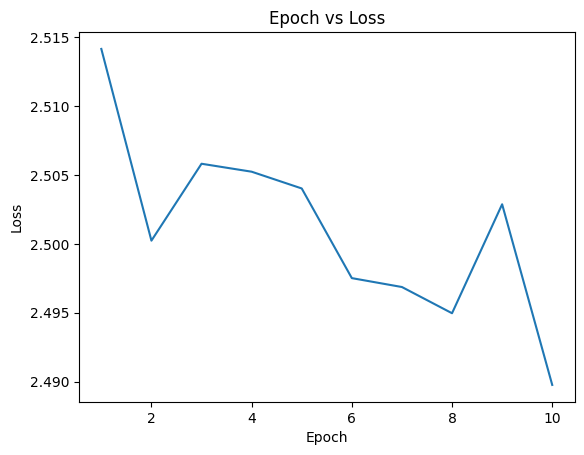

In [39]:
if __name__ == "__main__":
    train()